# Removing snakes to simplify quantum circuit models.

The snake removal procedure implemented in __rigidcat.normal_form()__ takes a diagram in a free rigid category and removes all the cups and caps that can be yanked using the snake equation, following the scheme from [Dunn, Vicary (2019)](https://arxiv.org/abs/1601.05372).

__Antonin's lemma:__
Given a diagram in a free rigid category such that the domain and codomain of every box and of the diagram itself are built from the basic types Ty('s') and Ty('n') only using tensor, it must have __rigidcat.normal_form()__ equal to a diagram where all cups and caps have been removed. [Delpeuch (2019)](https://arxiv.org/abs/1411.3827).

We start by generating grammatical sentences from a simple language, then we define the functor A which decomposes each word into simpler components. By Antonin's lemma, applying this functor followed by __normal_form()__ will return simplified diagrams, without changing their semantics. We use this procedure to simplify the interpretation of sentences as parametrised quantum circuits. 

## Language generation

In [1]:
from discopy import Ty, Box, Diagram, Word, pregroup

# Pregroup types for words are built using adjoints of basic types

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, who, is_rich, loves, Bob]

In [2]:
from time import time
from discopy.pregroup import brute_force

gen, n_sentences = brute_force(*vocab), 15
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("{:.2f} seconds to generate {} sentences.\n".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who is rich loves Alice.
Alice who is rich loves Bob.
Alice who loves Alice is rich.
Alice who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Bob who loves Alice is rich.
7.14 seconds to generate 15 sentences.



## Snake removal

In [3]:
from discopy import Cup, Cap, RigidFunctor

# The types of the following boxes are built from the basic types Ty('s') and Ty('n') only using tensor.

love_box = Box('loves', n @ n, s)
is_rich_box = Box('is rich', n, s)
copy = Box('copy', n, n @ n)
update = Box('update', n @ s, n)

# Define the Autonomization functor that decomposes a word into word_boxes:

ob = {n: n, s: s}
ar = {Alice: Alice,
      Bob: Bob,
      loves: Cap(n.r, n) @ Cap(n, n.l) >> Diagram.id(n.r) @ love_box @ Diagram.id(n.l),
      is_rich: Cap(n.r, n) >> Diagram.id(n.r) @ is_rich_box,
      who: Cap(n.r, n) >> Diagram.id(n.r) @ (copy >> Diagram.id(n) @ Cap(s, s.l) @ Diagram.id(n) >>
                                             update @ Diagram.id(s.l @ n))
     }

A = RigidFunctor(ob, ar, ob_cls=Ty, ar_cls=Diagram)

Autonomization of 'loves':


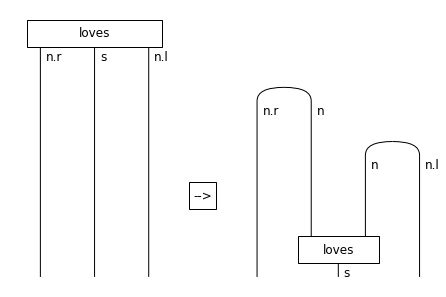

In [4]:
print("Autonomization of 'loves':")

(loves @ Box('-->', Ty(), Ty()) @ A(loves)).interchange(1, 2, left=True).interchange(2, 3).draw()

Autonomization of 'who':


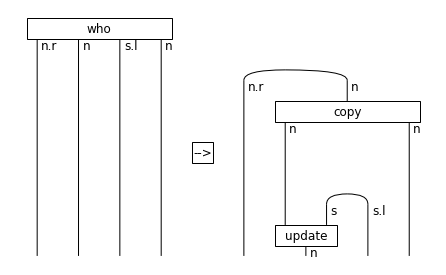

In [5]:
print("Autonomization of 'who':")

(who @ Box('-->', Ty(), Ty()) @ A(who)).interchange(1, 2, left=True).interchange(2, 3).draw()

Pregroup parsing for the sentence: 'Bob who is rich loves Alice.'


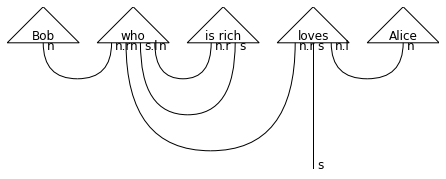

In [6]:
print("Pregroup parsing for the sentence: '{}'".format(sentences[12]))
pregroup.draw(parsing[sentences[12]])

In [7]:
from discopy import *
from IPython.display import HTML
FOLDER = '../docs/imgs/'
def inormalize(diagram, gif, **params):
    diagram.to_gif(FOLDER + gif, loop=False, timestep=1000, **params)
    return HTML('<img src="{}">'.format(FOLDER + gif))

print("Removing snakes from autonomisation of '{}'".format(sentences[12]))
inormalize(A(parsing[sentences[12]]), 'unsnake-sentence.gif', aspect='auto')

Removing snakes from autonomisation of 'Bob who is rich loves Alice.'


In [8]:
# Check that sentences after autonomisation and snake removal do not contain cups or caps

def has_cups_or_caps(diagram):
    for box in diagram.boxes:
        if isinstance(box, Cup) or isinstance(box, Cap):
            return True
    return False

autonomised_sentences = [A(parsing[sentences[i]]).normal_form() for i in range(n_sentences)]

for i in range(n_sentences):
    assert not has_cups_or_caps(autonomised_sentences[i])

## Quantum circuit models

Circuit for 'loves':


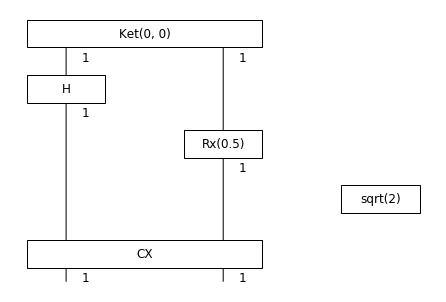

In [9]:
from discopy.circuit import Circuit, PRO, Id, CX, H, Rx, Ket, sqrt, SWAP, CircuitFunctor
import jax.numpy as np

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0) @ Ket(0) >> H @ Rx(phase) >> CX

def who_ansatz():
    return sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

def split_ansatz():
    return Circuit.id(1) @ Ket(0) >> CX

def update_ansatz():
    return Circuit.id(1)

# Use ansatzes to define the semantics of 

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    who: who_ansatz(),
    Bob: Ket(1),
    is_rich: intransitive_ansatz(params['is_rich']),
    copy: split_ansatz(),
    update: update_ansatz(),
    love_box: transitive_ansatz(- params['loves']).dagger(),
    is_rich_box: intransitive_ansatz(- params['is_rich']).dagger()}

F = lambda params: CircuitFunctor(ob, ar({'loves': params[0], 'is_rich': params[1]}))

# Initialise parameters
params0 = np.array([0.5, 1.])
F0 = F(params0)
print("Circuit for 'loves':")
F0(loves).normal_form().draw(aspect='auto')

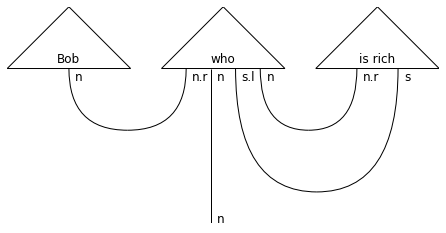

Circuit for noun phrase 'Bob who is rich':


In [18]:
from discopy.pregroup import eager_parse

noun_phrase = eager_parse(Bob, who, is_rich, target=n)
pregroup.draw(noun_phrase)

print("Circuit for noun phrase 'Bob who is rich':")
inormalize(F0(noun_phrase), 'fuse-kets.gif', draw_types=False, aspect='auto', fontsize=7)

In [11]:
# depth of the above circuit, excluding preparation and measurement layers. 
print('depth = {}'.format(F(params0)(noun_phrase).depth() - 2))
print('width = {}'.format(F(params0)(noun_phrase).width()))

depth = 6
width = 5


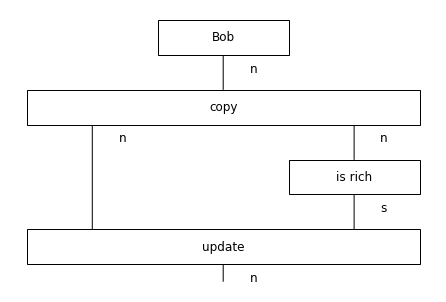

Equivalent circuit after snake removal:


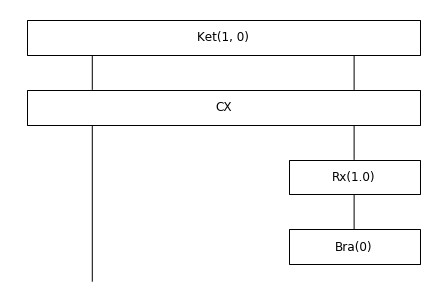

depth = 2
width = 2


In [17]:
A(noun_phrase).normal_form().draw(aspect='auto')
print("Equivalent circuit after snake removal:")
circuit = F0(A(noun_phrase).normal_form()).normal_form()
circuit.draw(draw_types=False, aspect='auto')
print('depth = {}'.format(circuit.depth() - 2))
print('width = {}'.format(circuit.width()))

In [13]:
# Check that the two circuits above generate the same distribution:
assert np.allclose((F0(noun_phrase).measure()), F(params0)(A(noun_phrase).normal_form()).measure())

Circuit for 'Bob who is rich loves Alice.':


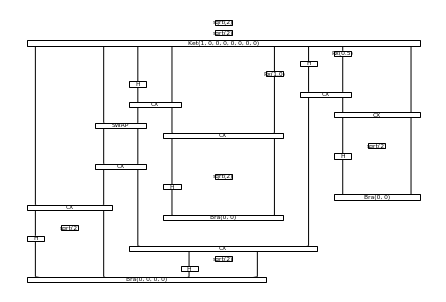

depth = 7
width = 8


In [20]:
print("Circuit for '{}':".format(sentences[12]))
circuit = F0(parsing[sentences[12]]).normal_form().normal_form()
circuit.draw(draw_types=False, aspect='auto', fontsize=6)
print('depth = {}'.format(circuit.depth() - 2))
print('width = {}'.format(circuit.width()))

Equivalent circuit after snake removal:


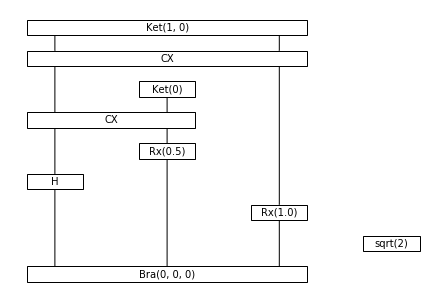

depth = 4
width = 3


In [15]:
print("Equivalent circuit after snake removal:")
circuit = F0(autonomised_sentences[12]).normal_form()
circuit.draw(draw_types=False, aspect='auto', fontsize=10)
print('depth = {}'.format(circuit.depth() - 2))
print('width = {}'.format(circuit.width()))

In [16]:
# Check that the two circuits above generate the same distribution:
assert np.allclose(F0(parsing[sentences[12]]).measure(), F(params0)(autonomised_sentences[12]).measure())